In [ ]:
# Take x samples, display to output. Output is a 2-column subplot with the standard input and normalised variant of a random image sample. 

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import plotly.subplots as subplots

def norm_image(arr):
    img_norm = np.array(arr)
    img_norm = (img_norm - np.min(img_norm))/np.ptp(img_norm) # Normalisation of z-values (RGB values; 3rd axis) to between 0 and 1
    return img_norm


fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=["Unnormalised (0 to 255)", "Normalised (0 to 1)"], horizontal_spacing=0.1)
fig.update_layout(title_text="Side-by-Side sample image comparison, unnormalised and normalised")


for sample in training_img_dataset.take(1):
  # sample = np.array(sample)
  sample = sample[0] # Take the first item in the sample. This is because sample is of size (BATCH_SIZE, WIDTH, HEIGHT, RGB)
  fig.append_trace(go.Image(z=sample), 1, 1)
  fig.append_trace(go.Image(z=norm_image(sample), zmin=[0, 0, 0, 0], zmax=[1, 1, 1, 1]), 1, 2)
  break


fig.show()

NameError: ignored

In [ ]:
# REMOVE: printing out all of the image files TF has loaded. As shown by the counter, k, this includes *all* of the input samples. 

all_samples = training_img_dataset.list_files(file_pattern='./data/**/**.jpg', shuffle=False)
k = 0
for x in all_samples:
  print(x)
  k += 1

print(f'Total samples: {k}')

In [ ]:
import pandas as pd
import math

labels = pd.read_csv(f'{DATA_DIRECTORY}/metadata_lookup.csv')

# print(labels.head())


all_samples = labels.sample(frac=1, random_state=42) # TODO: add a constant for the random states in pandas, numpy and keras/tensorflow shuffle variables

train_split, test_split, val_split = 0.7, 0.2, 0.1 # 4000, 1000, 500

try:
  assert math.fsum([train_split, test_split, val_split]) == 1
except AssertionError:
  print("The train, test and validation split ratios must sum to exactly 1.0!")
  print(f"Actual sum was {sum([train_split, test_split, val_split])}; train, test, val = {train_split}, {test_split}, {val_split}")
  raise

slices = [int(train_split * len(all_samples)), int((train_split + test_split) * len(all_samples))]

train_ds = all_samples.iloc[:slices[0]]
test_ds = all_samples.iloc[slices[0]:slices[1]]
val_ds = all_samples.iloc[slices[1]:]

# print(train_ds)
# print(test_ds)
# print(val_ds)

print(f'Split dataset into sample sizes of: train: {len(train_ds)}, test: {len(test_ds)}, val: {len(val_ds)}')

In [ ]:
# Download and extract the image dataset

!rm -r data
!gdown --id 13MRa51YRElF8n88Kh7RMglJCqSrTmrcg

import zipfile
with zipfile.ZipFile(f'./data.zip', 'r') as zip:
    zip.extractall('.')
!rm data.zip

Downloading...
From: https://drive.google.com/uc?id=13MRa51YRElF8n88Kh7RMglJCqSrTmrcg
To: /content/data.zip
100% 15.1M/15.1M [00:00<00:00, 77.2MB/s]


In [1]:
# Establishing constants

DATA_DIRECTORY = './data'
BATCH_SIZE=32
IMAGE_SIZE=(224, 224) # Width x height
INPUT_SHAPE=(224, 224, 3) # Width x height x colour profile (RGB; 3 channels)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf


data_df = pd.read_csv(f'{DATA_DIRECTORY}/metadata_lookup.csv')
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0, 
    horizontal_flip=True, 
    # rotation_range=90
    )

data_generator_from_df = data_generator.flow_from_dataframe(
    dataframe=data_df, 
    directory=DATA_DIRECTORY, 
    x_col='file_name', 
    y_col=['age', 'gender'], 
    # has_ext=True, #Deprecated
    batch_size=BATCH_SIZE, 
    shuffle=True,
    target_size=IMAGE_SIZE, 
    color_mode='rgb', 
    class_mode='raw')

Found 5000 validated image filenames.


In [3]:
import numpy as np

image_data, label_data = [], []
batch_index = 0

while batch_index <= data_generator_from_df.batch_index:
    data = data_generator_from_df.next()
    image_data.extend(data[0])
    label_data.extend(data[1])
    batch_index = batch_index + 1
image_data, label_data = np.array(image_data), np.array(label_data)

In [4]:
print(image_data.shape)
print(label_data.shape)

label_data_age, label_data_gender = label_data[:, 0], label_data[:, 1]

(5000, 224, 224, 3)
(5000, 2)


In [5]:
#Check GPU exists and is in use

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7449601650205603546
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7591611386254698310
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 222, 222, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 111, 111, 32  0          ['conv2d_4[0][0]']               
                                )                                                           

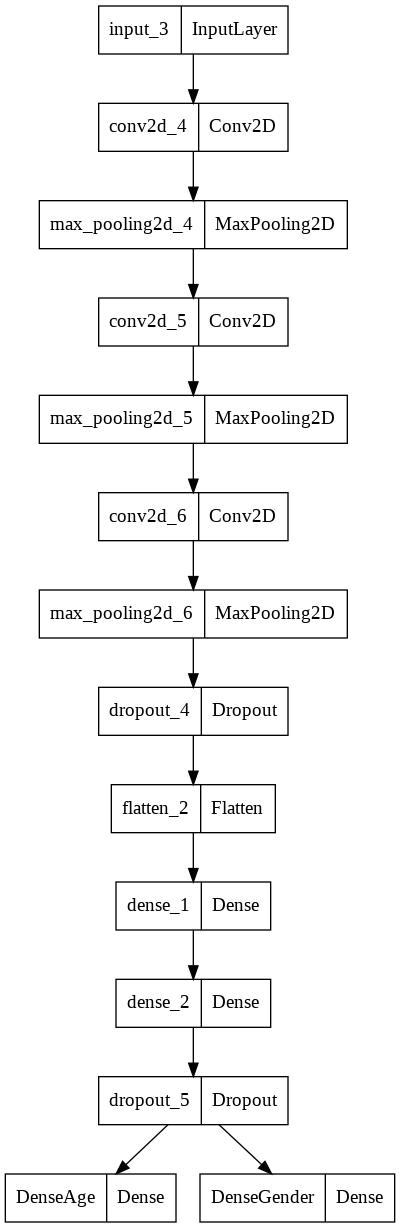

In [18]:
# Define the model using the Functional API

from tensorflow.keras import layers
import keras

# tf.debugging.set_log_device_placement(True) # Uncomment to verify Keras is running the model on the GPU

input = keras.Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)

out_age = layers.Dense(1, activation="relu", name="DenseAge")(x) # Using ReLU activation to skip negative values, as the age will never be negative
out_gender = layers.Dense(1, activation="sigmoid", name="DenseGender")(x) # Using sigmoid to limit 0 <= x <= 1
model = keras.models.Model(inputs = input, outputs = [out_age, out_gender])


# x = layers.Conv2D(64, kernel_size=(3, 3))(input)
# x = layers.Conv2D(64, kernel_size=(3, 3))(x)

# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(128, kernel_size=(3, 3))(x)
# x = layers.Conv2D(128, kernel_size=(3, 3))(x)

# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(256, kernel_size=(3, 3))(x)
# x = layers.Conv2D(256, kernel_size=(3, 3))(x)
# x = layers.Conv2D(256, kernel_size=(3, 3))(x)

# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(512, kernel_size=(3, 3))(x)
# x = layers.Conv2D(512, kernel_size=(3, 3))(x)
# x = layers.Conv2D(512, kernel_size=(3, 3))(x)

# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(512, kernel_size=(3, 3))(x)
# x = layers.Conv2D(512, kernel_size=(3, 3))(x)
# x = layers.Conv2D(512, kernel_size=(3, 3))(x)

# x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = layers.Flatten()(x)
# x = layers.Dense(4096, activation="relu")(x)
# x = layers.Dense(4096, activation="relu")(x)
# x = layers.Dropout(0.5)(x)


# out_age = layers.Dense(1, activation="relu", name="DenseAge")(x) # Using ReLU activation to skip negative values, as the age will never be negative
# out_gender = layers.Dense(1, activation="sigmoid", name="DenseGender")(x) # Using sigmoid to limit 0 <= x <= 1
# model = keras.models.Model(inputs = input, outputs = [out_age, out_gender])



model.summary()
tf.keras.utils.plot_model(
    model
)

In [ ]:
model.compile(
    loss = {
        "DenseAge": 'mean_absolute_error',
        "DenseGender": 'binary_crossentropy'
    },

    metrics = {
        "DenseAge": 'mean_absolute_error',
        "DenseGender": 'binary_accuracy'
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

history = model.fit(
    x = image_data,
    y = {'DenseAge': label_data_age, 'DenseGender': label_data_gender},
    steps_per_epoch = 50,
    validation_steps = 50,
    validation_split = 0.25,
    epochs = 30)

In [ ]:
print('Final val MAE on age:', str(history.history['val_DenseAge_mean_absolute_error'][-1]))
print('Final val binary accuracy on gender:', str(history.history['val_DenseGender_binary_accuracy'][-1]))

In [ ]:
import datetime
import json
from pathlib import Path

final_loss = str(round(history.history['val_loss'][-1], 5))
final_datetime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
file_name = f'{final_datetime} - {final_loss}'

Path(f'/outputs/{file_name}').mkdir(parents=True, exist_ok=True)

model.save(f'./outputs/{file_name}/model.h5')

with open(f'./outputs/{file_name}/config.json', 'w', encoding='utf8') as j:
    j.write(json.dumps(model.get_config()))
    
with open(f'./outputs/{file_name}/results.json', 'w', encoding='utf8') as j:
    j.write(json.dumps(history.history))

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
# !zip -r outputs.zip ./outputs